In [65]:
import chardet
import os
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD   
from nltk.tokenize import word_tokenize
import nltk
from fuzzywuzzy import fuzz

In [85]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()

    result = chardet.detect(raw_data)
    return result['encoding']

def srt_to_text(srt_file_path):
    encoding_attempts = ['utf-8', 'ISO-8859-1', 'utf-16', ]

    for encoding in encoding_attempts:
        try:
            with open(srt_file_path, 'r', encoding=encoding) as file:
                lines = file.readlines()

            text = ""
            current_line = ""
            is_time_line = True

            for line in lines:
                line = line.strip()

                if not line:
                    is_time_line = True
                    continue

                if is_time_line:
                    is_time_line = False
                    continue

                current_line += line + " "

                # If the line ends with a punctuation indicating the end of a sentence
                if line.endswith(('.', '!', '?')):
                    text += current_line + "\n"
                    current_line = ""

            return text.strip()
        except UnicodeDecodeError:
            None

    # If none of the encodings work
    print(f"Unable to decode file: {srt_file_path}")
    return None

def process_srt_files_in_folder(folder_path):
    result_dict = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".srt"):
            srt_file_path = os.path.join(folder_path, filename)
            text_content = srt_to_text(srt_file_path)

            if text_content is not None:
                file_dict = {"name": filename, "text": text_content}
                result_dict.append(file_dict)

    return result_dict

# Example usage for a folder containing SRT files
wally = '/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/1. Fourth Year/INFO 6350 - Text Mining History and Literature/INFO6350_Final_Project/srt_files'
casey = '/Users/caseykaufman/Documents/GitHub/INFO6350_Final_Project/srt_files'

folder_path = wally

result_dictionary = process_srt_files_in_folder(folder_path)

In [86]:
movie_subtitles_df = pd.DataFrame(result_dictionary)

In [87]:
# Removal of timestamps
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3}[\s-]+', '\n', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'<font.*?>|<\/font>', '', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\bdownloaded.*?|subtitles downloaded.*?|http.*?|www.*?', '', regex=True, flags=re.IGNORECASE)

In [88]:
pd.options.display.max_rows = 400

In [89]:
years = []
for name_index in range(len(movie_subtitles_df['name'])):
    found_year = False
    for letter_index in range(len(movie_subtitles_df['name'][name_index])):
        if movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '19' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit() or movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '20' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit():
            y = movie_subtitles_df['name'][name_index][letter_index:letter_index+4]
            years.append(y)
            found_year = True
            break
    if not found_year:
        years.append('na')

In [90]:
movie_subtitles_df['years'] = years

In [91]:
#cleaning names
pattern1= r'^([^\d(]+)(?:\.\d{4}| \(\d{4}\))?\.?[^\w]*'
pattern2 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}\b'
pattern3 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}-'

clean_names = []
for file_name in movie_subtitles_df['name']:
    match = re.match(pattern1, file_name) or re.match(pattern2, file_name) or re.match(pattern3, file_name)
    if match:
        extracted_name = match.group(1).replace('.', ' ')
        clean_names.append(extracted_name)
    else:
        print("Name extraction pattern not found for:", file_name)
        
new = [name.split('WWW')[0].strip() if 'WWW' in name else name for name in clean_names]
clean_names = [x.replace('-','') for x in new]

In [92]:
movie_subtitles_df['Movie Name'] = clean_names

In [93]:
#adding win/loss
excel = pd.read_csv('scripts.csv')

#getting index values
highest = []
for films in clean_names: 
    similarity = []
    indexes = []
    for all_films in excel['Film']:
        sim = fuzz.ratio(str(films), str(all_films))
        similarity.append(sim)
    highest.append(similarity.index(max(similarity)))
    
movie_name_check = []
win_loss = []
for idx in highest:
    value1 = excel.loc[idx,'Film']
    value2 = excel.loc[idx,'Win']
    movie_name_check.append(value1)
    win_loss.append(value2)
    
movie_subtitles_df['Similarity Calc Name'] = movie_name_check
movie_subtitles_df['Win or Loss'] = win_loss

In [94]:
movie_subtitles_df.head()

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0


## Basic Processing and Data Exploration

In [95]:
# Function to count tokens in a text
def count_tokens(text):
    tokens = nltk.word_tokenize(text)
    return len(tokens)

movie_subtitles_df['num_tokens'] = [count_tokens(movie_subtitles_df['text'][i]) for i in range(len(movie_subtitles_df['text']))]

In [96]:
movie_subtitles_df

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss,num_tokens
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0,15458
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0,16868
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0,15171
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0,9986
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0,15581
5,Designing.Woman.1957.720p.BluRay.x264-[YTS.AM]...,\nMy name's Mike Hagen. \n\nI'm a sportswriter...,1957,Designing Woman,Designing Woman,1.0,17993
6,The Tin Star (1957).srt,\nJust getting the feel of these guns. \n\nWhe...,1957,The Tin Star,The Tin Star,0.0,9226
7,In Which We Serve (1942) - Eng Sub.srt,\nThis is the story of a ship \n(Cheering) \n(...,1942,In Which We Serve,In Which We Serve,0.0,14327
8,Houseboat 1958 720p WEB-DL AAC2.0 H.264-brento...,\nWhat do you know... \nHe finally made it. \n...,1958,Houseboat,Houseboat,0.0,13111
9,Ace in the hole (1951) Eng.srt,\nHey. Pull up at the corner. \n\nWait here. \...,1951,Ace in the hole,Ace in the Hole,0.0,15970


#### Number of Tokens by Year

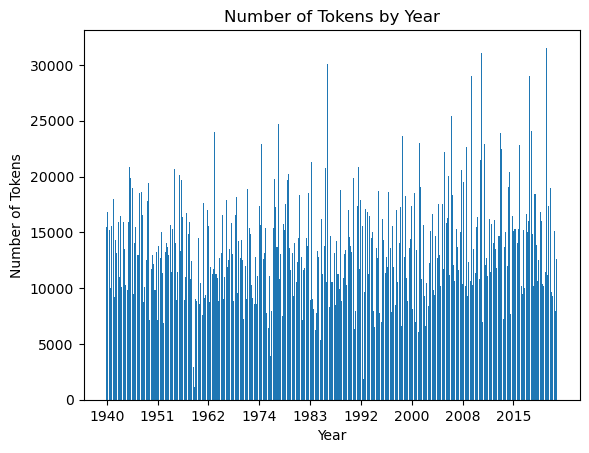

In [97]:
# Filter out rows with 'na' in the 'years' column
movie_subtitles_df = movie_subtitles_df[movie_subtitles_df['years'] != 'na']

# Sort the DataFrame by 'years' in ascending order
movie_subtitles_df = movie_subtitles_df.sort_values(by='years')

# Set x-axis ticks to show only once every other 20 years
step = 40  # Adjust the step value as needed
plt.xticks(range(0, len(movie_subtitles_df['years']), step), movie_subtitles_df['years'][::step])

# Create a bar chart
plt.bar(movie_subtitles_df.index, movie_subtitles_df['num_tokens'])
plt.xlabel('Year')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens by Year')

plt.show()

In [98]:
min_index = movie_subtitles_df['num_tokens'].idxmin()
min_index

69

In [102]:
print(movie_subtitles_df.loc[min_index])
print(movie_subtitles_df.loc[min_index]['text'])


name                    The.Artist.2011.720p.BluRay.x264-LOST.english.srt
text                    \nJean Dujardin \nBerenice Bejo \nTHE ARTIST \...
years                                                                2011
Movie Name                                                    The Artist 
Similarity Calc Name                                           The Artist
Win or Loss                                                           0.0
num_tokens                                                           1163
Name: 69, dtype: object

Jean Dujardin 
Berenice Bejo 
THE ARTIST 
James Cromwell 
Penelope Ann Miller 
Malcolm McDowell Missi Pyle 
Beth Grant, Ed Lauter Joel Murray, Ken Davitian 
and John Goodman 
Produced by Thomas Langmann 
Written & Directed by Michel Hazanavicius 
"I won't talk! 
I won't say a word!!!" 
"Speak!" 
"Speak!" 
Please, be silent behind the screen 
" Long live free Georgia!!!" 
" I will get you for this." 
"A Russian Affair" George Valentin 
That's the questio

Minimum number of tokens in all scripts:  1163
Maximum number of tokens in all scripts:  31547


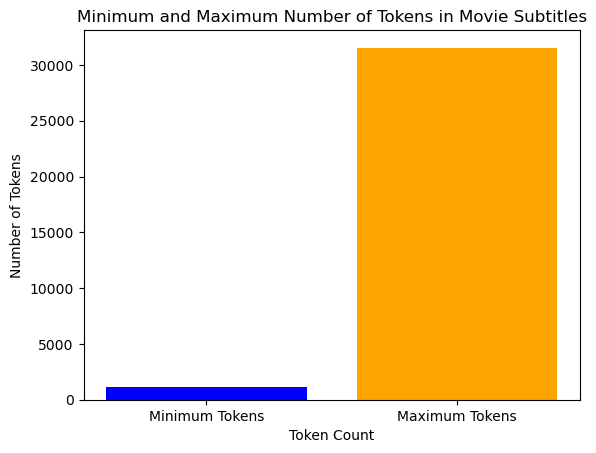

In [100]:
# Minimum number of tokens versus maximum number of tokens
min_tokens = min(movie_subtitles_df['num_tokens'])
max_tokens = max(movie_subtitles_df['num_tokens'])

print('Minimum number of tokens in all scripts: ', min_tokens)
print('Maximum number of tokens in all scripts: ', max_tokens)

# Plotting the data
labels = ['Minimum Tokens', 'Maximum Tokens']
values = [min_tokens, max_tokens]

plt.bar(labels, values, color=['blue', 'orange'])
plt.xlabel('Token Count')
plt.ylabel('Number of Tokens')
plt.title('Minimum and Maximum Number of Tokens in Movie Subtitles')
plt.show()

#### Longest sentence versus shortest sentence

## Create Chunks of Tokens out of the Paragraphs

In [49]:
# Create a topic model based on chunking with chunk size 200 tokens

def generate_chunks(paragraphs, movie, year, chunk_size=200):
    chunks = []
    chunk_movie_name = []
    chunk_year = []

    for i in range(len(paragraphs)):
        text = paragraphs.iloc[i]  # Extract the text from the Series
        newsletter_type = movie.iloc[i]
        date = year.iloc[i]

        # Split the text into paragraphs using '\n'
        text_paragraphs = text.split('\n')

        current_chunk = []
        current_chunk_movie_name = []

        for paragraph in text_paragraphs:
            # Check if the length of the paragraph exceeds the chunk size
            if len(paragraph) > chunk_size:
                chunks.append(paragraph)
                chunk_movie_name.append(newsletter_type)
                chunk_year.append(date)
            else:
                # If not, add the paragraph to the current chunk
                current_chunk.append(paragraph)
                current_chunk_movie_name.append(newsletter_type)

                # Check if the current chunk size exceeds the specified limit
                if len(' '.join(current_chunk)) > chunk_size:
                    chunks.append(' '.join(current_chunk))
                    chunk_year.extend([date])
                    chunk_movie_name.append(newsletter_type)
                    current_chunk = []
                    current_chunk_movie_name = []

        # Add any remaining paragraphs to the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))
            chunk_year.extend([date])
            chunk_movie_name.append(newsletter_type)

    return chunks, chunk_movie_name, chunk_year

# Generate chunks
text_chunks, chunk_movie_name, chunk_year = generate_chunks(movie_subtitles_df['text'], movie_subtitles_df['name'], movie_subtitles_df['years'])

## Vectorize

In [50]:
# # Vectorizer
# vectorizer = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
#     input = 'content',
#     encoding = 'utf-8',
#     strip_accents = 'unicode',
#     #stop_words='english', # uncomment to remove fixed stops from input
#     lowercase = True,
#     min_df = 0.001, # Remember that we've chunked by paragraph
#     max_df = 0.25    # Ditto
# )

In [51]:
# # Vectorize
# vectorizer = TfidfVectorizer(use_idf=True, norm=None)

In [52]:
# # Vectorized texts
# X_chunked = vectorizer.fit_transform(text_chunks)

# #X_topics_chunked = StandardScaler().fit_transform(lda.fit_transform(X_chunked))

## Unsupervised Cluster Analysis
Using K-Means

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, norm='l2', binary=False, min_df=2, max_df=0.8)

In [19]:
y_pred = KMeans(n_clusters=2, n_init='auto').fit_predict(X_chunked)

In [20]:
# Plotting function
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        svd = TruncatedSVD(n_components=3)
        X_2d = svd.fit_transform(X)
    else:
        X_2d = X

    # initialize figsize in prompt
    plt.figure(figsize=(12, 6))

    # left subplot, alpha value in function cell
    plt.subplot(121)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=alpha)
    plt.title("Dimension-Reduced Unclustered Data")

    # right subplot, same coordinate data and supplied cluster labels, alpha value in function cell
    plt.subplot(122)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=alpha)
    plt.title("Data with Clustering")

    # Set the common title for the entire figure
    plt.title(title)

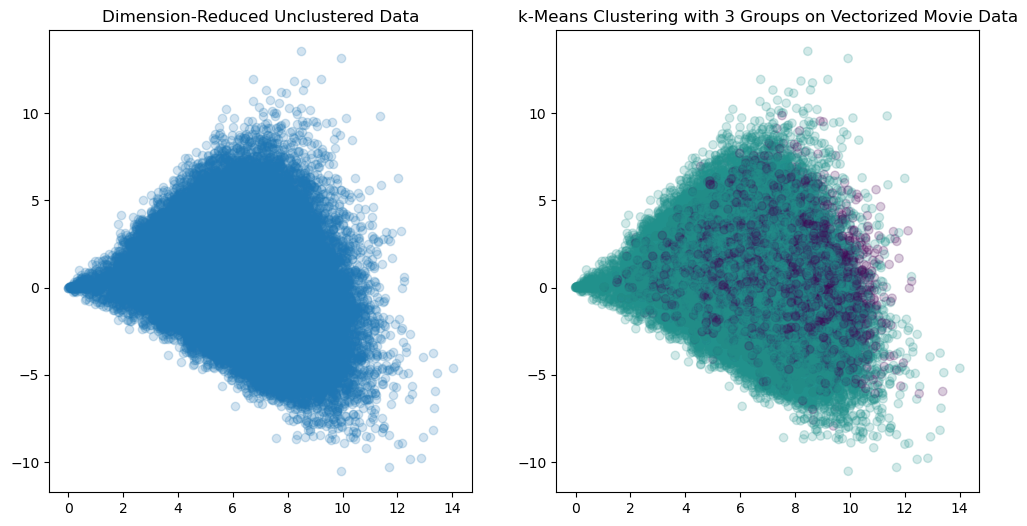

In [21]:
# plot resulting clustering
plot_compare(X_chunked, y_pred, 'k-Means Clustering with 3 Groups on Vectorized Movie Data')

# Topic Model

In [22]:
lda = LatentDirichletAllocation(
    n_components=20, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=0,       # Print progress
    max_iter=30,     # Might want more in production work
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X_chunked)

LatentDirichletAllocation(evaluate_every=0, max_iter=30, n_components=20,
                          n_jobs=-1)

In [23]:
def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)
        print(message)
    print()

In [24]:
print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: sir hello yes the you mr please thank good to
Topic  1: bye you it the oh good thank beautiful and very
Topic  2: the of in and is its music earth wall by
Topic  3: dog sighs laughing blood trust mike eye game you your
Topic  4: new the and was year she it in york that
Topic  5: he him you to the wait his in ll what
Topic  6: you to it don what do me know that can
Topic  7: the 00 frank harry and of you meeting in paper
Topic  8: the of is to body and in rich professor human
Topic  9: the king lt yοu thе south north america tο san
Topic 10: door the music john fire david mama ray playing on
Topic 11: the of mr to and in is will that for
Topic 12: you hey on get it come right yeah gonna up
Topic 13: three the two five four fight years 000 minutes six
Topic 14: was the and of they ve that he you it
Topic 15: you ok it thinking yeah the no oh and coffee
Topic 16: the her and she in plane 12 of horse fly
Topic 17: sam la speaking english de vous french doc je fat
Topic 18: the of